Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Found 201073 validated image filenames.
Found 22341 validated image filenames.
Found 234 validated image filenames.
(224, 224, 3)
6284/6284 [==============================] - ETA: 0s - batch: 3141.5000 - size: 31.9976 - loss: nan - auc_1: 0.5000 - categorical_accuracy: 0.0986

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


6284/6284 [==============================] - 8465s 1s/step - batch: 3141.5000 - size: 31.9976 - loss: nan - auc_1: 0.5000 - categorical_accuracy: 0.0986 - val_loss: nan - val_auc_1: 0.5000 - val_categorical_accuracy: 0.1152
dict_keys(['loss', 'auc_1', 'categorical_accuracy', 'val_loss', 'val_auc_1', 'val_categorical_accuracy'])


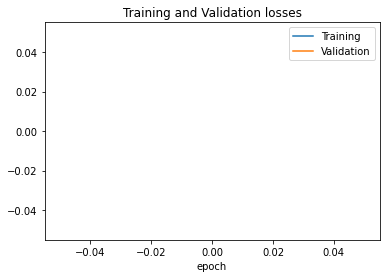

KeyError: ignored

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
classes = ['No Finding', 'Enlarged Cardiomediastinum',
               'Cardiomegaly', 'Lung Opacity',
               'Lung Lesion', 'Edema', 'Consolidation',
               'Pneumonia', 'Atelectasis', 'Pneumothorax',
               'Pleural Effusion', 'Pleural Other',
               'Fracture', 'Support Devices']


def data_generator(train_df, val_df):
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    dataGen_train = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rescale=1. / 255,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.2,
        zoom_range=.2,
        fill_mode='nearest',
        validation_split=0.1)
    paths_for_normalizing = train_df['Path'].sample(frac=5e-3).to_numpy()
    images_for_normalizing = np.array([np.array(cv2.imread(img_path, 1), dtype=float) for img_path in paths_for_normalizing])
    normalization_sample = np.array([x for x in images_for_normalizing if x.shape == (320, 390, 3)])
    dataGen_train.fit(normalization_sample)




    train_generator = dataGen_train.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col=classes,
        seed=42,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training'
    )
    val_generator = dataGen_train.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col=classes,
        seed=42,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='Path',
        y_col=classes,
        shuffle=False,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw')
    print(train_generator.image_shape)
    return train_generator, val_generator, test_generator


def read_csv(dataset_dir):
  train_df = pd.read_csv(dataset_dir + 'train.csv')
  val_df = pd.read_csv(dataset_dir + 'valid.csv')
  return train_df, val_df

import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import tensorflow as tf
from keras import layers
from tensorflow.keras.applications import DenseNet169

def build_model(model, module):
    """model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(14, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(14, activation='sigmoid'))
    model.summary()"""
    model.add(module)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(14, activation='sigmoid'))
    conv_base.trainable = True
    model.summary()
    return model


def run_and_evaluator(model, dataset_dir):
    train_df, val_df = read_csv(dataset_dir)
    model.compile(Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[metrics.AUC(), metrics.categorical_accuracy])
    (train_generator, validation_generator, test_generator) = data_generator(train_df, val_df)
    history = model.fit(train_generator, epochs=1,validation_data=validation_generator,verbose=1)
    print(history.history.keys())
    model.save('/content/CheXpert-v1.0-small/CheXpert.h5')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.title('Training and Validation losses')
    plt.xlabel('epoch')
    plt.show()

    plt.plot(history.history['auc_1'])
    plt.plot(history.history['val_auc_1'])
    plt.legend(['Training', 'Validation'])
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')
    plt.show()

    test_loss, test_acc = model.evaluate(test_generator)
    print('test loss: {} test acc: {}'.format(test_loss, test_acc))

    y_actual = val_df[classes].to_numpy()
    y_preds = model.predict_generator(test_generator, steps=test_generator.n)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k-')

    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_actual[:, i], y_preds[:, i])
        individual_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=(classes[i] + f' (AUC = {round(individual_auc, 3)})'))

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()


if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    tf.compat.v1.disable_eager_execution()
    dataset_dir = "/content/CheXpert-v1.0-small/"
    model = Sequential()
    conv_base = DenseNet169(include_top=False, weights='imagenet', input_shape=(224,224,3))
    conv_base.summary()
    model = build_model(model, conv_base)
    run_and_evaluator(model, dataset_dir)


In [ ]:
from google.colab import files
files.download('/content/CheXpert-v1.0-small/CheXpert.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! wget -c http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

--2021-09-30 12:58:08--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘CheXpert-v1.0-small.zip’

CheXpert-v1.0-small 100%[===================>]  10.76G  5.12MB/s    in 36m 46s 

2021-09-30 13:34:54 (5.00 MB/s) - ‘CheXpert-v1.0-small.zip’ saved [11557753157/11557753157]



In [ ]:
! ls
from zipfile import ZipFile

zf = ZipFile('CheXpert-v1.0-small.zip')
uncompressed_size = sum((file.file_size for file in zf.infolist()))
print('Uncompressed size:', uncompressed_size/1e9, 'GB.')

extracted_size = 0
extracted_percent = 0

for file in zf.infolist():
    extracted_size += file.file_size
    last_percent = extracted_percent
    extracted_percent = extracted_size * 100/uncompressed_size
    for i in range(10, 110, 10):
        if last_percent < i and extracted_percent >= i:
            print(str(i)+'% complete')
    try:
        zf.extract(file)
    except:
        continue

CheXpert-v1.0-small.zip  sample_data
Uncompressed size: 11.471429175 GB.
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete
